### Import Libraries

In [336]:
import pandas as pd
import numpy as np 
import os
import warnings
import missingno
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from IPython.display import display, HTML


warnings.filterwarnings('ignore')
%matplotlib inline

<!--  -->

### Load Data

In [337]:
input_file = os.getcwd()+"\\Data\\tennis_rf.csv"

df_tennis_data = pd.read_csv(input_file, sep=",")

<!--  -->

### Descriptive Info

In [338]:
print("Columns: {}\n".format(df_tennis_data.columns.to_list()))
print("Data shape: {}\n".format(df_tennis_data.shape))
print(df_tennis_data.info(),"\n")

Columns: ['outlook', 'temp', 'humidity', 'windy', 'play']

Data shape: (36, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   outlook   36 non-null     object
 1   temp      36 non-null     object
 2   humidity  36 non-null     object
 3   windy     36 non-null     bool  
 4   play      36 non-null     object
dtypes: bool(1), object(4)
memory usage: 1.3+ KB
None 



In [339]:
df_tennis_data.head(26)

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,no
4,rainy,cool,normal,False,no
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,no
9,rainy,mild,normal,False,no


<!--  -->

### Descriptive Stats

In [340]:
df_tennis_data.describe()

,outlook,temp,humidity,windy,play
count,36,36,36,36,36
unique,3,3,2,2,2
top,sunny,mild,high,False,no
freq,12,14,18,22,21


<!--  -->

### Missing Rows

In [341]:
df_tennis_data.isna().sum().reset_index().rename(columns={"index":"col", 0:"count"})

,col,count
0,outlook,0
1,temp,0
2,humidity,0
3,windy,0
4,play,0


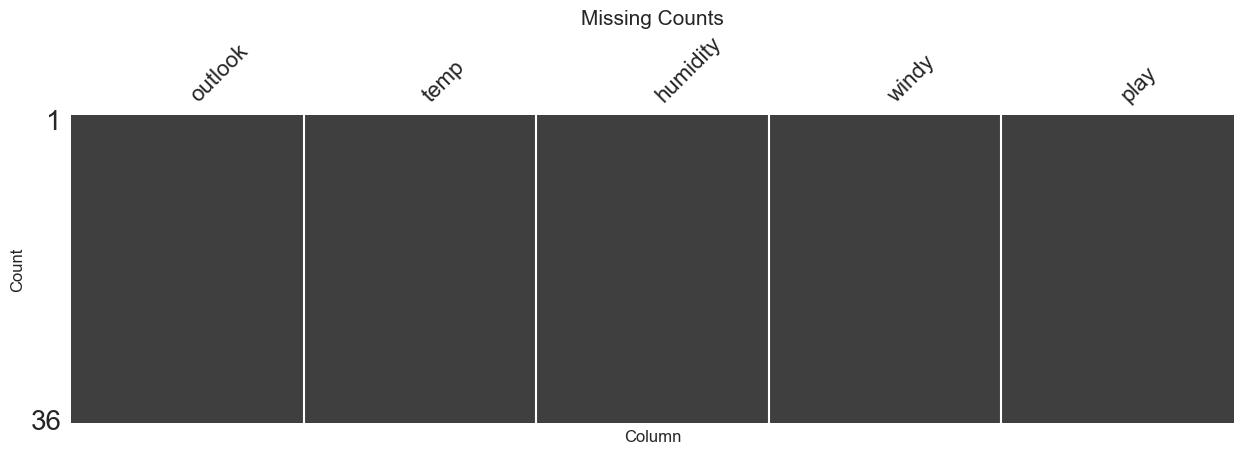

In [342]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))

missingno.matrix(df_tennis_data, ax=axes)
axes.set_title("Missing Counts", size=15)
axes.set_xlabel("Column", size=12)
axes.set_ylabel("Count", size=12)

plt.show()

Observation

- No missing values, hence no need to handle missing values issue

<!--  -->

### EDA

- **`Target Variable Distribution`**

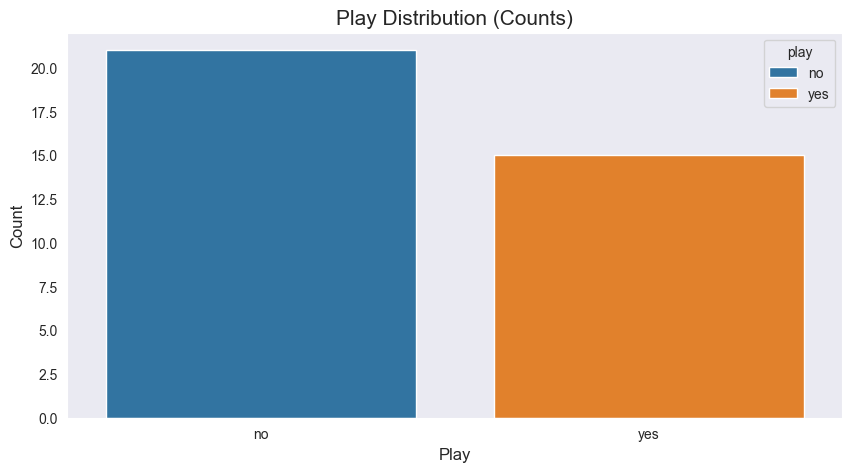

In [343]:
df_counts = df_tennis_data.groupby("play")["play"].value_counts().reset_index()

# Plot
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.barplot(x="play", y="count", data=df_counts, hue="play", legend=True, ax=axes)
axes.set_title("Play Distribution (Counts)", size=15)
axes.set_xlabel("Play", size=12)
axes.set_ylabel("Count", size=12)
axes.set_ylim(0, 22)
plt.show()

Observation 

- Reasonably balanced dataset, hence we can have good chance of having target variable's all classes in both train and test.

- **`Predictors vs Target Variable`**
    - Identifying potential outliers

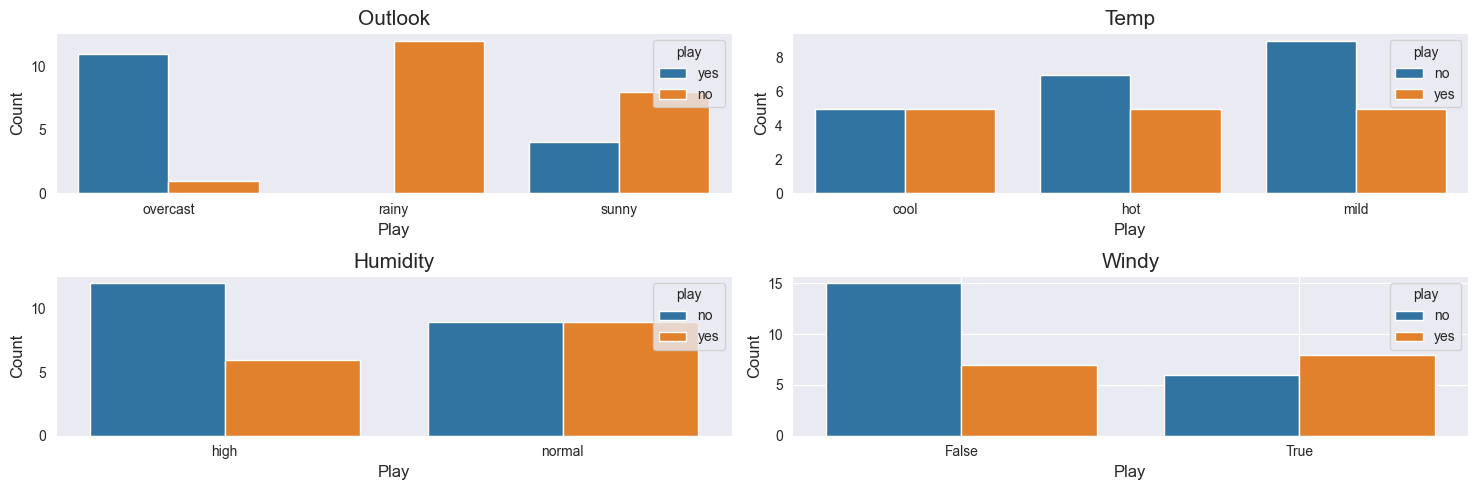

In [344]:
# Plot
sns.set_style("dark")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,5))

df_counts = df_tennis_data.groupby("outlook")["play"].value_counts().reset_index()
sns.barplot(x="outlook", y="count", data=df_counts, hue="play", legend=True, ax=axes[0][0])
axes[0][0].set_title("Outlook", size=15)
axes[0][0].set_xlabel("Play", size=12)
axes[0][0].set_ylabel("Count", size=12)

df_counts = df_tennis_data.groupby("temp")["play"].value_counts().reset_index()
sns.barplot(x="temp", y="count", data=df_counts, hue="play", legend=True, ax=axes[0][1])
axes[0][1].set_title("Temp", size=15)
axes[0][1].set_xlabel("Play", size=12)
axes[0][1].set_ylabel("Count", size=12)

df_counts = df_tennis_data.groupby("humidity")["play"].value_counts().reset_index()
sns.barplot(x="humidity", y="count", data=df_counts, hue="play", legend=True, ax=axes[1][0])
axes[1][0].set_title("Humidity", size=15)
axes[1][0].set_xlabel("Play", size=12)
axes[1][0].set_ylabel("Count", size=12)

df_counts = df_tennis_data.groupby("windy")["play"].value_counts().reset_index()
sns.barplot(x="windy", y="count", data=df_counts, hue="play", legend=True, ax=axes[1][1])
axes[1][1].set_title("Windy", size=15)
axes[1][1].set_xlabel("Play", size=12)
axes[1][1].set_ylabel("Count", size=12)

plt.grid(True)
plt.tight_layout()
plt.show()

Observation

- As predictors are all categorical, and there is no outliers in above, like having only one category as extremly high count than others.
- So, in this case we don't need to focus much on outliers detection  

<!--  -->

### Predictors Scaling

Observation 

- Feature scaling is not a mandatory step for Random Forest. These trees make splits based on thresholds on features, and scaling doesn't affect the order of values which is crucial for the splits.
- It's always a good practice to experiment with both scaled and unscaled data to see if it makes a difference for your specific dataset.
- Here, we are not focusing much on scaling as above predictors are categorical features. 

<!--  -->

### Categorical to Numerical Features Creation

In [345]:
df_tennis_data.value_counts()

outlook   temp  humidity  windy  play
overcast  cool  normal    True   yes     4
sunny     hot   high      False  no      4
rainy     mild  normal    False  no      4
overcast  hot   high      False  yes     3
rainy     mild  high      False  no      2
sunny     hot   high      True   no      2
rainy     mild  high      True   no      2
          cool  normal    True   no      2
                          False  no      2
overcast  mild  high      True   yes     2
          hot   normal    False  yes     2
sunny     mild  normal    True   yes     2
overcast  hot   high      False  no      1
sunny     cool  normal    False  no      1
                                 yes     1
          mild  high      False  no      1
                                 yes     1
Name: count, dtype: int64

- Manual Label Encoding 

In [346]:
# Defining natutal order less: low value --> high: higher value 
outlook_mapping = {'overcast': 1, 'rainy': 2, 'sunny': 3}
temp_mapping = {'cool': 1, 'mild': 2, 'hot': 3}
humidity_mapping = {'normal': 1, 'high': 2} 
windy_mapping = {False: 1, True: 2}

# Apply label encoding
df_tennis_data["outlook_encoding"] = df_tennis_data["outlook"].map(outlook_mapping)
df_tennis_data["temp_encoding"] = df_tennis_data["temp"].map(temp_mapping)
df_tennis_data["humidity_encoding"] = df_tennis_data["humidity"].map(humidity_mapping)
df_tennis_data["windy_encoding"] = df_tennis_data["windy"].map(windy_mapping)

df_tennis_data

,outlook,temp,humidity,windy,play,outlook_encoding,temp_encoding,humidity_encoding,windy_encoding
0,sunny,hot,high,False,no,3,3,2,1
1,sunny,hot,high,True,no,3,3,2,2
2,overcast,hot,high,False,yes,1,3,2,1
3,rainy,mild,high,False,no,2,2,2,1
4,rainy,cool,normal,False,no,2,1,1,1
5,rainy,cool,normal,True,no,2,1,1,2
6,overcast,cool,normal,True,yes,1,1,1,2
7,sunny,mild,high,False,no,3,2,2,1
8,sunny,cool,normal,False,no,3,1,1,1
9,rainy,mild,normal,False,no,2,2,1,1


<!--  -->

### Predictors Selection

In [347]:
df_tennis_data = df_tennis_data[["outlook_encoding", "temp_encoding", "humidity_encoding", "windy_encoding", "play"]]
df_tennis_data.head(5)

,outlook_encoding,temp_encoding,humidity_encoding,windy_encoding,play
0,3,3,2,1,no
1,3,3,2,2,no
2,1,3,2,1,yes
3,2,2,2,1,no
4,2,1,1,1,no


<!--  -->

### Train & Test Data Splits

In [348]:
X = df_tennis_data.drop(["play"], axis=1)
y = df_tennis_data["play"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=200)

- Train Data

In [349]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 23 to 26
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   outlook_encoding   30 non-null     int64
 1   temp_encoding      30 non-null     int64
 2   humidity_encoding  30 non-null     int64
 3   windy_encoding     30 non-null     int64
dtypes: int64(4)
memory usage: 1.2 KB


In [350]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 30 entries, 23 to 26
Series name: play
Non-Null Count  Dtype 
--------------  ----- 
30 non-null     object
dtypes: object(1)
memory usage: 480.0+ bytes


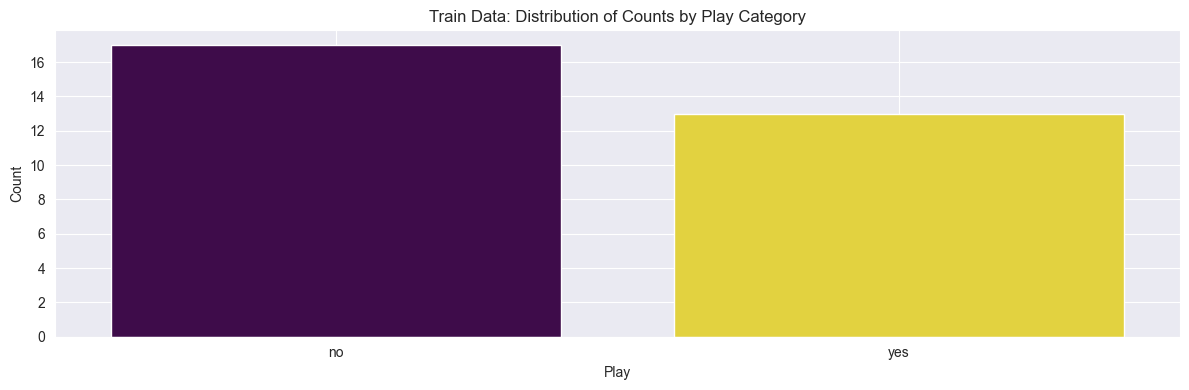

In [351]:
# Class counts
y_train_counts = y_train.value_counts().reset_index()

# Unique classes
categories = y_train_counts.play.unique()

# Colors per class
colors = plt.cm.get_cmap('viridis', len(categories)).colors

sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.barplot(x="play", y="count", data=y_train_counts, ax=axes, palette=colors)

plt.xlabel("Play")
plt.ylabel("Count")
plt.title("Train Data: Distribution of Counts by Play Category")

# plt.legend(categories)
plt.tight_layout()
plt.grid(True)
plt.show()

Observation

- Both classes exists in Train data

- Test Data

In [352]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 32 to 13
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   outlook_encoding   6 non-null      int64
 1   temp_encoding      6 non-null      int64
 2   humidity_encoding  6 non-null      int64
 3   windy_encoding     6 non-null      int64
dtypes: int64(4)
memory usage: 240.0 bytes


In [353]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 6 entries, 32 to 13
Series name: play
Non-Null Count  Dtype 
--------------  ----- 
6 non-null      object
dtypes: object(1)
memory usage: 96.0+ bytes


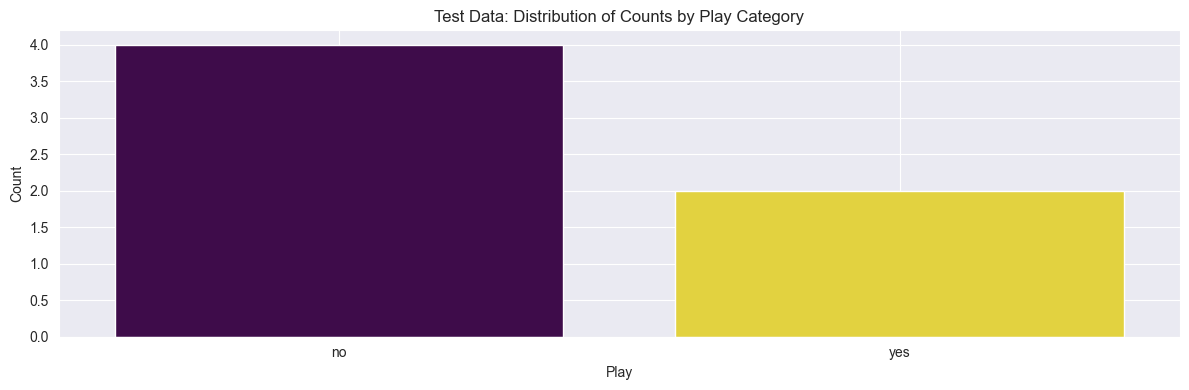

In [354]:
# Class counts
y_test_counts = y_test.value_counts().reset_index()

# Unique classes
categories = y_test_counts.play.unique()

# Colors per class
colors = plt.cm.get_cmap('viridis', len(categories)).colors

sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.barplot(x="play", y="count", data=y_test_counts, ax=axes, palette=colors)

plt.xlabel("Play")
plt.ylabel("Count")
plt.title("Test Data: Distribution of Counts by Play Category")

# plt.legend(categories)
plt.tight_layout()
plt.grid(True)
plt.show()

Observation

- Both classes exists in Test data

<!--  -->

### Model Training

- Random Search[Hyper Parameters Tuning]

In [355]:
rs_search_space = {
    'n_estimators': range(5, 40), # No. of random decision trees 
    'criterion': ["entropy", "gini"], # Split quality criteria metric
    'max_depth': range(5,20), # Max depth of the tree
    'min_samples_split': range(3, 10), # Min samples to split a node
    # 'verbose': 2, # This gives overview about each iteration output
    # 'max_features': ['sqrt', 'log2'] # This ise used to select random set columns for each decision tree to get train, but here we use all feature all predictors are not huge count in this case
}

In [356]:
# Initialise Random Forest Classifier
rf_classifier = RandomForestClassifier()

In [357]:
# Perform Hyper parameters Tuning
rf_rs = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=rs_search_space,
    n_iter=20, # Repeat the process for 20 times to validate on different parameters, random folds in each iteration, to get more realistic performing paramters
    cv=5, # 5 fold cross validation, to check random forest accuracy in all random folds test data, As here it small dataset using 5, but 10 fold cv is general rule of thumb to use in most of the cases
    n_jobs=-1, # Use all available CPU cores
    random_state=101 # For reproducing above 20 randomised iterations
)

In [358]:
# Fit model to data
rf_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': range(5, 20),
                                        'min_samples_split': range(3, 10),
                                        'n_estimators': range(5, 40)},
                   random_state=101)

- Model Training Evaluation
    - On Kfold's data sets

In [359]:
# Random Search Results
print("Best paramters/estimators as per random searc cross validation. {}".format(rf_rs.best_params_))
print('Mean accuray as per best parameters : {}\n'.format(rf_rs.best_score_))

Best paramters/estimators as per random searc cross validation. {'n_estimators': 29, 'min_samples_split': 4, 'max_depth': 10, 'criterion': 'gini'}
Mean accuray as per best parameters : 0.9



Observation 

- Model seems to be performing better in all K fold datasets, based on chosen hyper parameters during random search hyper parameters tuning

<!--  -->

### Model Evaluation
- On Test Data

In [360]:
# Predict on the test data using the best model
best_rf = rf_rs.best_estimator_
y_pred = best_rf.predict(X_test)

In [361]:
# Calculate and print the accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(accuracy))

Test set accuracy: 0.83


Observation

- Based on this small dataset, I would say Model is performing well with 83% accuracy. 
- If we can add more data to train, model can train on recurring patterns and predict further well.
- In ideal case, model should not be under (~50%) or over(99%) fitted model, there should be proper trade of between bias and variance in model training.

<!--  -->

### Model Interpretation

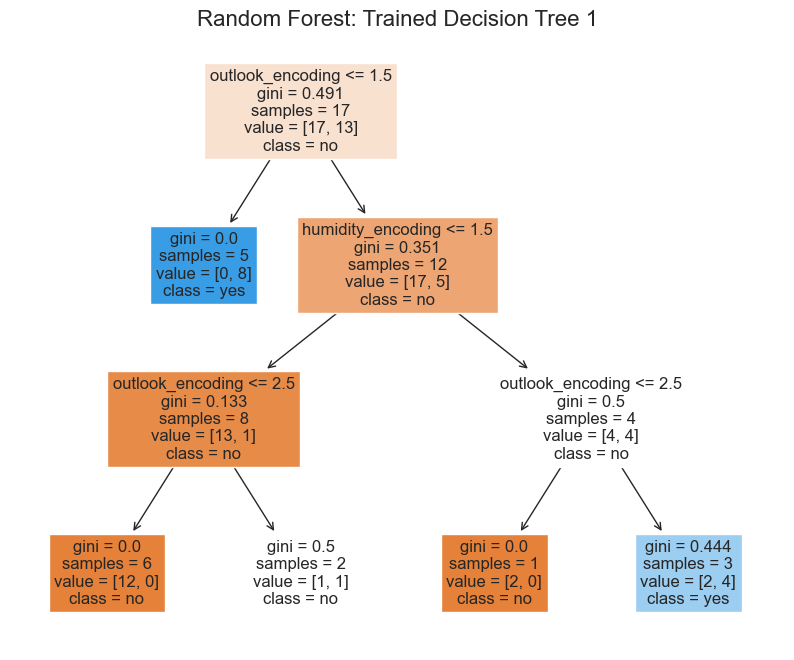

In [362]:
# Using plot_tree, ploting 2nd decision tree out of 11 estimators(i.e., base decision trees)
sns.set_style("dark")
fig = plt.figure(figsize=(10,8))
a = plot_tree(best_rf.estimators_[1], 
                feature_names=X_train.columns, 
                fontsize=12, 
                filled=True, 
                class_names=['no', 'yes'] # class_names=['no', 'yes'] # This order displays "no" on the right side of the tree and "yes" on the left side. Because in our data 1st class label is not play in resp. variable
)
plt.title("Random Forest: Trained Decision Tree 1", size=16)
plt.show()

In [310]:
df_tennis_data[(df_tennis_data["windy_encoding"]>1) & (df_tennis_data["outlook_encoding"]<=1)]

,outlook_encoding,temp_encoding,humidity_encoding,windy_encoding,play
6,1,1,1,2,yes
11,1,2,2,2,yes
16,1,1,1,2,yes
24,1,1,1,2,yes
29,1,2,2,2,yes
34,1,1,1,2,yes


Observation

- Here to understand how leaf value = [0, 5] as reached,
    - Tree 1 check whether windy_encoding <= 1.5, if condition ``yes`` goes to left split and ``no`` goes to right split. We want to learn right split i.e., values that are not <= 1.5 i.e., 2 (means windy=true records as per label encoding)
    - Then tree checks condition outlook_encoding <= 1.5, if condition ``yes`` goes to left split and ``no`` goes to right split. We want to learn left split i.e., values that are <= 1.5 i.e., 1 (means outlook=overcast records as per label encoding) 
    - Based on above data splits, we can see that there are 5 samples, out of which all are play class.
    - Meaning during prediction on new data point, when predictor value matches this conditions, then this decision tree vote for play, as it is majority of class in the leaf node.
    - Like wise all other decisions tree do their votes for prediction on new data points based on their tree's split conditions and at final based on majority of aggregated votes, final decision is taken.
    - This is how we can interpret the Random Forest model prediction.

In [312]:
# df_tennis_data[(df_tennis_data["windy_encoding"]>1) & (df_tennis_data["outlook_encoding"]>1)] # value = [6, 2]